In [1]:
import os
import cv2
from Astar import get_AStarPlanner
import apriltag
import numpy as np
from utils import *
from sift import judge
from PIL import Image
import matplotlib.pyplot as plt
import random

sh: ./stop_sys_ttyPS0.sh: No such file or directory


In [2]:
def updateImage():
    """更新img图像."""
    orig_img_path = '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'
    ! fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2
    img = Image.open(orig_img_path)
    return img

In [4]:
# function 1 计算Y方向的机器人世界坐标y_rob

def get_location():
    """实例化检测器并检测Apriltag."""
    img = updateImage()
    img = np.array(img)
#     img = cv2.imread('1.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    options = apriltag.DetectorOptions(families='tag36h11',)
    detector = apriltag.Detector(options)
    tags = detector.detect(gray)
#     print(tags)
    cnt = 0
    while len(tags) == 0 and cnt < 5:
        img = updateImage()
        img = np.array(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        tags = detector.detect(gray)
        cnt += 1
        if cnt == 5:
            run_action('turn003L')
            wait_req()
            cnt = 0
    
#     print(tags)
    # 获取pos和corners的代码
    tag_positions = load_tag_pos() 

    # 获取pos和corners的代码
    tag_num = len(tags)
    for n, tag in enumerate(tags):
#         print("debug here::",tag.tag_id)
#         if tag.tag_id > 41:
#             continue
        # 使用tag.id访问坐标，tag_positions的定义见前面，pos的形状为[4, 3]，分别代表已知的四个顶角在空间中的x,y,z三个坐标分量
        pos = tag_positions[str(tag.tag_id)]
#         print(pos)
        # 四个顶角在图片中的像素位置(形状为[4, 2]，分别代表四个顶角的像素空间坐标) 
        corners = np.array(tag.corners)
#         print(corners)
    # 2D坐标
    ImgPoints = corners
    # 3D坐标
    WorldPoints = pos
    # 内参矩阵
    fx = 192.0513
    fy = 194.1294
    cx = 311.9018
    cy = 233.6934
    intrinsic_matrix =  np.array([[fx,0,cx],
                                  [0,fy,cy],
                                  [0,0,1]],dtype = np.float64)
    # 畸变系数
    distCoeffs = np.array([0.2683,-0.2053,0,0])
    # 求解R和T的值
    retval, R, T = cv2.solvePnP(WorldPoints,ImgPoints,intrinsic_matrix,distCoeffs)
    rotM = cv2.Rodrigues(R)[0]
    cameraPosition = -np.matrix(rotM).T * np.matrix(T)
    # R矩阵的第三行
    direction = np.matrix(rotM)[2]
    # print("朝向::",direction)
    x_robot = cameraPosition[0]
    y_robot = cameraPosition[1]
    
    dirXY = direction[:,:2]
    normdir = dirXY / np.linalg.norm(dirXY)
    
    return y_robot.tolist()[0][0],x_robot.tolist()[0][0],normdir # 使用numpy.tolist()转化为int类型

In [5]:
def rotate_to_balance(target):
    """调整机器人朝向。
    Args:
        target (float): 目标朝向的角度。
    """
    
    _,_,dirs= get_location()
    theta = angle(dirs)

    # 设置一个物理上的零点,可供机器人调参数
    distance = theta - target
    distance = (distance-360) if distance > 180 else distance
    distance = (distance+360) if distance < -180 else distance
    # if distance > 180:
    #     distance -= 360
    # if distance < -180:
    #     distance += 360

    if abs(distance) > 90: # 优化版了rotate函数,对于转弯过大的情况单独处理
        print("distance is too large:let's turn a big angle!")
        if distance > 0:
            run_action('turn010L')
            wait_req()
            run_action('turn010L')
            wait_req()
        else:
            run_action('turn010R')
            wait_req()
            run_action('turn010R')
            wait_req()
    if abs(distance) > 30:
        print("distance is too large:let's turn a big angle!")
        if distance > 0:
            run_action('turn010L')
            wait_req()
        else:
            run_action('turn010R')
            wait_req()
    elif abs(distance) > 15:
        print("distance is too large:let's turn a big angle!")
        if distance > 0:
            run_action('turn005L')
            wait_req()
        else:
            run_action('turn005R')
            wait_req()

    # 设定阈值为5度
    while abs(distance) > 5:
        if distance > 0:
            run_action('turn001L')
        if distance < 0:
            run_action('turn001R')
        _,_,dirs= get_location()
        theta = angle(dirs)
        distance = theta - target
        print("Adjusting angle: theta=",theta)
        print("Target angle:", target)

    # 最后再微调一下
    if distance > 0.5:
        run_action('turn001L')
    if distance < -0.5:
        run_action('turn001R')
    print("Adjusting angle completed! Theta=",theta)
    
    return

In [7]:
# 获得下一个点的二维坐标，并移动
def move_to_next(rx, ry):
    next_loction_X,next_loction_Y = rx[0],ry[0]
    Y,X,direction = get_location()
    # 转向
    move_dir = np.array([[next_loction_X-X, next_loction_Y-Y]])
    print("move_dir = ",move_dir)
    norm_move_dir = move_dir / np.linalg.norm(move_dir)
    print("norm_move_dir = ",norm_move_dir)

    # 确定目标角度
    target_theta = angle(norm_move_dir)
    print('目标角度是：',target_theta)
    rotate_to_balance(target_theta)

    # straight = merge(rx,ry)

    # if straight == True:
    #     # 说明有较长的直线距离
    #     # 向前走三次
    #     for i in range(3):
    #         run_action('Forwalk02')
    #         wait_req()
    #         run_action('turn001L')
    #         wait_req()
    # else:
    #     # 说明不可以一直走直线
    run_action('Forwalk02')
    wait_req()
    run_action('turn001L')
    wait_req()

min_x: 0
min_y: 0
max_x: 294
max_y: 294
x_width: 37
y_width: 37
Find goal
[16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 136, 136, 136, 136, 136, 136, 136, 136, 144, 152, 160, 168] [16, 16, 16, 16, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200]


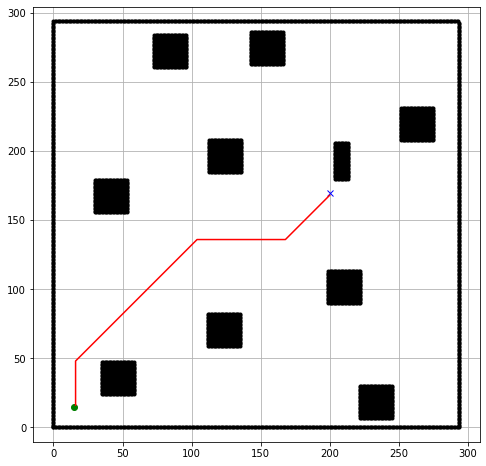

In [18]:
a_star = get_AStarPlanner(grid_size=8)
sx = 15
sy = 15
tx = 170
ty = 200
rx, ry = a_star.planning(sx, sy, tx, ty)
plt.plot(sy, sx, "og")
plt.plot(ty, tx, "xb")
plt.plot(ry, rx, "-r")
print(rx,ry)

In [11]:
def Go(sx,sy,tx,ty):
    a_star = get_AStarPlanner(grid_size=8)
    rx, ry = a_star.planning(sx, sy, tx, ty)
    while len(rx) > 1 or len(ry) > 1:
        move_to_next(rx=rx,ry=ry)
        Y,X,direction = get_location()
        sx,sy = int(X),int(Y)
        rx, ry = a_star.planning(sx, sy, tx, ty)
        print(rx,ry)
        
    print("到达终点!")
    return 0

In [ ]:
screen_center_relative_pos = [16, -10]
# 按钮相对于TAG左下角的位置（cm）
button_relative_pos = [7, -9]


class ExtraInfoLoader():

    def __init__(self, 
                 tagpos_dict: dict,
                 button_relative_pos: list = [7, -9],
                 screen_center_relative_pos: list = [16, -10],
                 ) -> None:
        """
        params:
        - tagpos_dict: provider by function `load_tag_pos`
        - button_relative_pos: location of button relative to the lower-left corner of the tag
        - screen_center_relative_pos: location of button relative to the lower-left corner of the tag
        """
        self.tagpos_dict = tagpos_dict
        self.button_rloc = button_relative_pos
        self.screen_rloc = screen_center_relative_pos
        
    @staticmethod
    def get_normal(point):
        x = point[1] - point[0]
        y = point[2] - point[1]
        return ExtraInfoLoader.cross_prod(y, x)

    @staticmethod
    def cross_prod(x, y):
        z = np.array([
            x[1] * y[2] - x[2] * y[1],
            x[2] * y[0] - x[0] * y[2],
            x[0] * y[1] - x[1] * y[0]
        ])
        z = z / (((z * z).sum())**0.5)
        return z

    def get_extra_info(self, tag_id: int):
        """
        ### params:
        - tag_id: integer tag id

        ### returns:
        - button_pos: 3D location of the center of the button corresponding to this tag
        - screen_pos: 3D location of the center of the screen corresponding to this tag
        - face: a 3D unit vector representing the facing direction of this tag
        """

        assert isinstance(tag_id, int) and tag_id >= 43 and tag_id <=71, \
            "tag_id must be an integer within [43, 71]"

        tag_loc = self.tagpos_dict[str(tag_id)]
        LL = tag_loc[0,...]

        face = self.get_normal(tag_loc)
        actual_y = np.array([0, 0, -1])
        actial_x = self.cross_prod(face, actual_y)

        # 按钮的坐标
        button_pos = LL + actual_y * self.button_rloc[1] + actial_x * self.button_rloc[0]
        # 屏幕中心的坐标
        screen_pos = LL + actual_y * self.screen_rloc[1] + actial_x * self.screen_rloc[0]

        return button_pos, screen_pos, face

In [ ]:
def refine(x,y,dir):
    '''
    首先调节到x和y,再调方向
    '''
    move_to_next(next_loction_X=x,next_loction_Y=y)

    target_theta = angle(dir)
    rotate_to_balance(target_theta)

    return 0

In [ ]:
def rush(pillar):
    '''冲向按钮的函数'''
    # 调整一次位置
    # refine(x=pillar[0][0],y=pillar[0][1],dir=pillar[1])
    # 冲到按钮的位置,实际上可以加入微调的模块
    run_action('fastForward03')
    wait_req()
    # 再调整一次朝向
    rotate_to_balance(pillar[1])
    wait_req()
    # 冲向按钮撞击按钮
    print('冲啊！！！')

    run_action('fastForward05')
    return 0

def leave(step):
    '''从按按钮位置远离的函数'''
    for i in range(step):
        run_action('Back2Run')
        wait_req()
    return 0

In [ ]:
def decision():
    """_summary_

    Returns:
        int: 识别到的花编号（如果没识别到为0）。
        int: 识别到花旁边的apriltag编号。
    """
    # 输出识别花的种类，以及tag的标识编号
    # 判断自己是不是在好格点, 如果在， 扭头拍屏幕进行判断
    # 这个70不确定！是指侧面右上角的tag标识编号
    goodnodes = [[150,120,[70,71]]]


    Y,X,direction = get_location()
    for goodnode in goodnodes:
        distance = (X-goodnode[0])^2 + (Y-goodnode[1])^2
        if distance < 25:
            print('good place, decision!')
            
            # 开始转头，拍拍
            for extent in ['180 ','140','MM','020','010']:
                k ='HeadTurn'+ extent
                run_action(k)
                wait_req()
                img = updateImage()
                img = np.array(img)

                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                options = apriltag.DetectorOptions(families='tag36h11',)
                detector = apriltag.Detector(options)
                H,W = gray.shape
                gray_cut = gray[:,W//4:3*W//4]
                tags = detector.detect(gray_cut)
                tags_ids = [tag.tag_id for tag in tags]

                # 识别到需要看的侧面，然后对其花朵进行识别
                for goodtag_id in goodnode[2]:
                    if goodtag_id in tags_ids:
                        for i in range(1,7):
                            target_img = cv2.imread('flower/%s.jpg'%i, 1)
                            if judge(img1=img, img2=target_img, threshold=10):
                                print("识别成功！类别为：%s"%i)
                                return i, goodtag_id
                        return 0, goodtag_id
            
        # 没有在goodnode旁边 / 向左向右看完都没有成功识别goodnode的tag 
        return 0, 0


In [ ]:
def Gobest(sx,sy, fx,fy, correct_type):
    EIL = ExtraInfoLoader(load_tag_pos())
    a_star = get_AStarPlanner(grid_size=30)
    rx, ry = a_star.planning(sx, sy, fx, fy)
    i = 1
    while i < len(rx):  
        flower_type, tag_id = decision()
        # 回正脑袋
        run_action('Back2Run')
        wait_req()

        if flower_type == correct_type :
            print("找到了正确的！")

            # 调整位置和朝向
            button_pos, s, screen_orientation = EIL.get_extra_info(tag_id)
            rush_dir = [-screen_orientation[0], -screen_orientation[1]]
            rush_location = button_pos - 40 * rush_dir
            move_to_next(rush_location[0], rush_location[1])
            target_theta = angle(rush_dir)
            rotate_to_balance(target_theta)

            # 冲冲！
            pillar=[rush_location, rush_dir]
            rush(pillar)

            # 远离
            leave(2)
         
        move_to_next(rx[i],ry[i])
        i+=1

In [18]:
Y,X,direction = get_location()
print("Robot的Y坐标为:",Y)
print("Robot的X坐标为:",X)
print("朝向为:",direction)
theta = angle(direction)
print("角度为:",theta)

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
Robot的Y坐标为: 128.289119651
Robot的X坐标为: 266.336318887
朝向为: [[-0.99992291  0.01241699]]
角度为: [[-0.71148047]]


In [ ]:
Go(int(X),int(Y),25,25)
plt.show()

In [ ]:
move_to_next([266],[128])

In [ ]:
for i in range(3):
    run_action('Forwalk02')
    wait_req()
    run_action('turn001L')
    wait_req()

In [ ]:
# case 1:
# 起点:[280, 120] 终点:[20, 180]  
# 具体过程点：[280,116], [280,124], [230,120], [230,170], [180,170], [130,170], [80,170], [30,170], [20, 180]

# 距离40cm进行冲撞，中间柱子面点:( , ),( , )

# TODO:
# 1.从起点出发依次到达中间柱子面点前方,进行识别算法,如果正确,调用rush()函数按按钮
# 2.退回合适位置,开始规划到终点路线
# 3.到达终点,再调研rush()函数按按钮:或者前面按了则不按

In [ ]:
# case 2:
# 起点:[20,86] 终点:[165,260] 
# 具体过程点：[20,86], [20,130], [20,180], [60,180], [60,220], [60,260], [115,260], [165,260]
# 中间柱子面点:( , ),( , )


# TODO:
# 1.从起点出发依次到达中间柱子面点前方,进行识别算法,如果正确,调用rush()函数按按钮
# 2.退回合适位置,开始规划到终点路线
# 3.到达终点,再调研rush()函数按按钮:或者前面按了则不按

In [ ]:
# case 3:
# 起点:( , ) 终点:( , ) 中间柱子面点:( , ),( , )


# TODO:
# 1.从起点出发依次到达中间柱子面点前方,进行识别算法,如果正确,调用rush()函数按按钮
# 2.退回合适位置,开始规划到终点路线
# 3.到达终点,再调研rush()函数按按钮:或者前面按了则不按

In [ ]:
# case 4:
# 起点:( , ) 终点:( , ) 中间柱子面点:( , ),( , )
# TODO:
# 1.从起点出发依次到达中间柱子面点前方,进行识别算法,如果正确,调用rush()函数按按钮
# 2.退回合适位置,开始规划到终点路线
# 3.到达终点,再调研rush()函数按按钮:或者前面按了则不按
